# LOFAR LoTSS DR2 cutout matching
In this example, we'll take a chunk of the `LoTSS_DR2_v110.gaus.fits` LOFAR source catalogue, convert it to a `WODEN` sky model, run it through a `WODEN` simulation, and try and match a postage stampl cutout from the actual LoTSS survey.

First up, what let's look at what we're trying to emulate. I went to the [LoTSS DR2 cutout service](https://vo.astron.nl/lotss_dr2/q/query_mosaics/form) and grabbed the nearest cut out to `RA, Dec = 180.0, 50.0`. That retuned the `P18Hetdex03` field, which looks like this: 

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np 

with fits.open('P18Hetdex03_mosaic-blanked.fits') as hdu:
    wcs = WCS(hdu[0].header).celestial
    pix_res = np.abs(hdu[0].header['CDELT1'])
    cent_x = hdu[0].header['CRPIX1']
    cent_y = hdu[0].header['CRPIX2']
    
    cent_ra = hdu[0].header['CRVAL1']
    cent_dec = hdu[0].header['CRVAL2']
    
    cat_freq = hdu[0].header['RESTFRQ']
    
    data = np.squeeze(hdu[0].data)

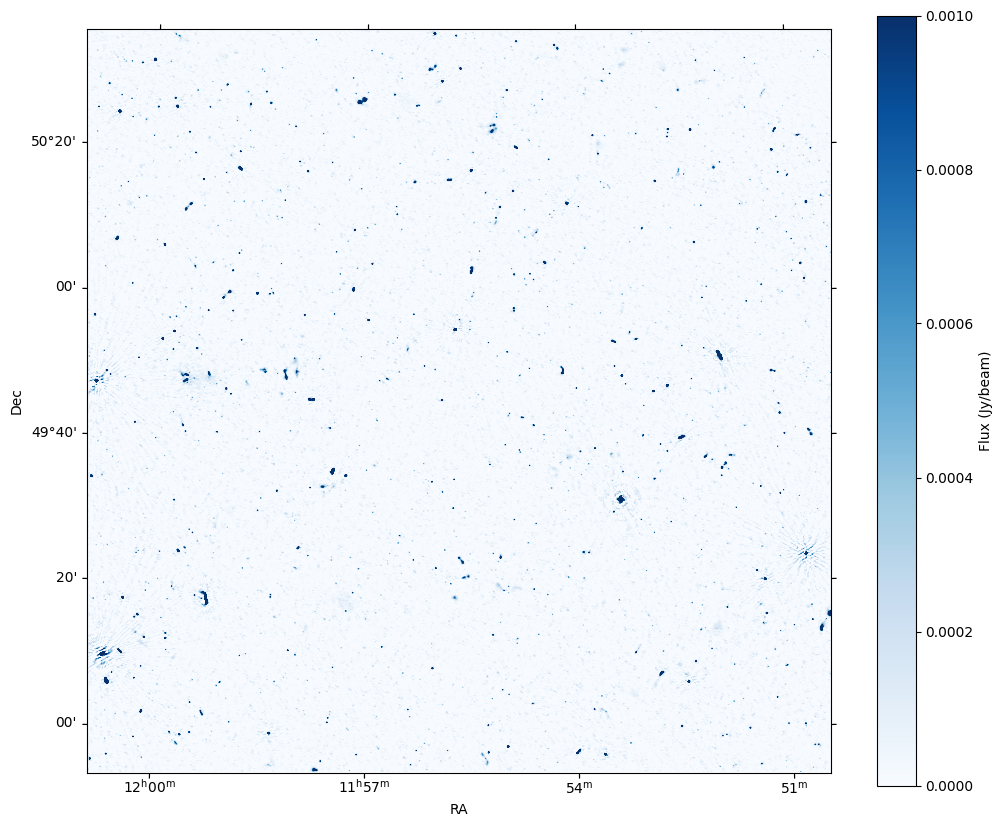

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, subplot_kw={'projection': wcs}, figsize=(12, 10))
im = axs.imshow(data, origin='lower', cmap='Blues', vmin=0, vmax=1e-3)

half_width=2048

axs.set_xlim(cent_x - half_width, cent_x + half_width)
axs.set_ylim(cent_y - half_width, cent_y + half_width)


axs.set_xlabel('RA')
axs.set_ylabel('Dec')

plt.colorbar(im, ax=axs, label='Flux (Jy/beam)')
plt.show()

That's a spicy meatball! Super high res and deep image. Checking the [LoTSS data products page](https://lofar-surveys.org/dr2_release.html) I can find `Non-redundant Gaussian catalogue v1.1`. Clicking that downloads the `LoTSS_DR2_v110.gaus.fits` file. Hopefully as this is a Gaussian catalogue, it should give us a realistic looking sky model. First up, let's load the catalogue.

In [3]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
import numpy as np 

table_lotss = Table.read('LoTSS_DR2_v110.gaus.fits')
unq_source_ids = np.array(table_lotss['Source_Name'], dtype='U32')
##order everything by source name to make adding converting into a WODEN
##style table easier
ordering = np.argsort(unq_source_ids)
unq_source_ids = unq_source_ids[ordering]
ras = table_lotss['RA'][ordering]
decs = table_lotss['DEC'][ordering]
fluxes = table_lotss['Total_flux'][ordering]/1000.0
majors = table_lotss['DC_Maj'][ordering]/3600.0
minors = table_lotss['DC_Min'][ordering]/3600.0
pas = table_lotss['PA'][ordering]


##Make some astropy skycoords
coords = SkyCoord(ras, decs, unit='deg')
##Make a skycoord for the image centre
image_centre = SkyCoord(cent_ra, cent_dec, unit='deg')
##Find separation of all catalogue sources from image centre
separations = image_centre.separation(coords).degree

Next, we'll trim to catalogue down to sources that fit within a degree from the centre of our cutout image. Plot it over the cutout image to sanity check everything.

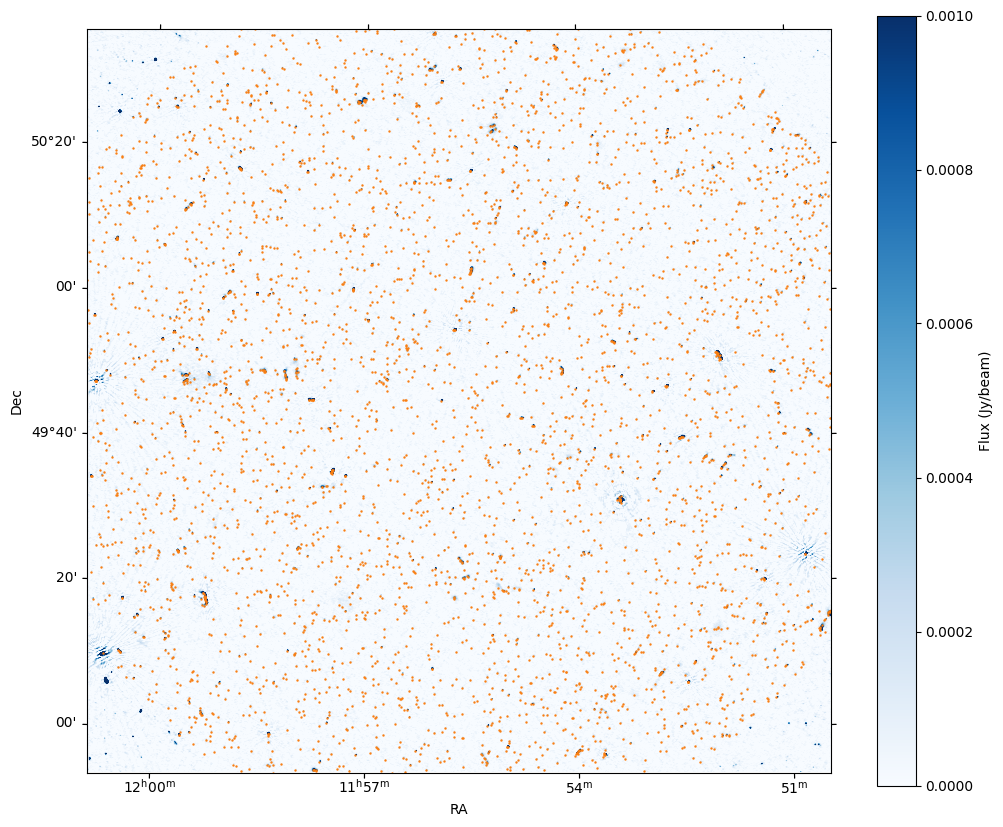

In [4]:
subset = np.where(separations < 1.0)


ra_subset = ras[subset]
dec_subset = decs[subset]

x_sub, y_sub = wcs.all_world2pix(ra_subset, dec_subset, 0)


fig, axs = plt.subplots(1, 1, subplot_kw={'projection': wcs}, figsize=(12, 10))
im = axs.imshow(data, origin='lower', cmap='Blues', vmin=0, vmax=1e-3)

axs.scatter(x_sub, y_sub, marker='.', s=2, edgecolor='C1', alpha=1.0)

half_width=2048

axs.set_xlim(cent_x - half_width, cent_x + half_width)
axs.set_ylim(cent_y - half_width, cent_y + half_width)


axs.set_xlabel('RA')
axs.set_ylabel('Dec')

plt.colorbar(im, ax=axs, label='Flux (Jy/beam)')
plt.show()

We've defo go the correct coverage! Weirdly, all the sources seem slightly offset from the cutout image. Maybe the catalogue has been ionospherically corrected and the image hasn't? Anyways, should still be good enough to run through `WODEN`. Let's convert it to something that `WODEN` can understand.

In [5]:
##First up, only use the subset we've just defined
num_comps = len(subset[0])

unq_source_ids_use = unq_source_ids[subset]
ras_use = ras[subset]
decs_use = decs[subset]
fluxes_use = fluxes[subset]
majors_use = majors[subset]
minors_use = minors[subset]
pas_use = pas[subset]
##Catalogue doesn't see to come with spectral index so just set to -0.8
alphas = np.full(num_comps, -0.8)

print('Number of components:', num_comps)

Number of components: 4995


Next, get the naming convention that the `WODEN` catalogue needs (based on the LoBES survey, also used by `hyperdrive`). It needs to have a column called `UNQ_SOURCE_ID`, which is the name of the parent source for any catalogue entry. It also needs a `NAME` column, which is the name of the parent source plus `f"_C{comp_ind}"` where `comp_ind` is the component index within that source. `WODEN` uses this to group components from the same source together, useful if you want to crop below the horizon by source.

Anyways, we've loaded the `Source_Name` column from the LoTSS catalogue as `unq_source_ids`. So we can use this to form the `NAME` column.

In [6]:

##Grabs all unique names, the indexes of the first occurance, and how many times
##that name appears
unq_names, unq_indexes, unq_counts = np.unique(unq_source_ids_use, return_index=True, return_counts=True)

names = np.empty(num_comps, dtype='U32')
for unq_name, unq_index, unq_count in zip(unq_names, unq_indexes, unq_counts):
    ##If there is more than one component with the same name, iterate
    ##over them            
    if unq_count > 1:
        for comp_id in range(unq_count):
            names[unq_index + comp_id] = f"{unq_name}_C{comp_id:03d}"
    ##Otherwise just set the name to the original name + C000
    else:
        names[unq_index] = f"{unq_name}_C000"
        

Beyond that, fluxes are all reported at 200 MHz, so we need to scale from the native 144 MHz. Again, just assume we have spectral index of -0.8 everywhere for this.

In [7]:
extrap_freq = 200e+6
alpha = -0.8
fluxes_extrap = fluxes_use*(extrap_freq/cat_freq)**alpha

One other `WODEN` thing we need is the `COMP_TYPE` column, that tells us whether it's a Gaussian or a Point source. We'll set anything with a Major axis of 0 as a point source.

In [8]:
comp_types = np.empty(num_comps, dtype='U3')
comp_types[majors_use == 0.0] = 'P'
comp_types[majors_use != 0.0] = 'G'

Now we just reassemble the other columns with new names and write out the catalogue.

In [9]:
from astropy.table import Column

unq_source_id_col = Column(unq_source_ids_use, name='UNQ_SOURCE_ID')
names_col = Column(names, name='NAME')

ras_col = Column(ras_use, name='RA', unit='deg')
decs_col = Column(decs_use, name='DEC', unit='deg')
fluxes_col = Column(fluxes_extrap, name='NORM_COMP_PL', unit='Jy')
si_col = Column(alphas, name='ALPHA_PL', unit='Jy')
majors_col = Column(majors_use, name='MAJOR_DC', unit='deg')
minors_col = Column(majors_use, name='MINOR_DC', unit='deg')
pas_col = Column(pas_use, name='PA_DC', unit='deg')
comp_types_col = Column(comp_types, name='COMP_TYPE')
##We're inputting everything as a power law
mod_types_col = Column(np.full(num_comps, 'pl'), name='MOD_TYPE')

cols = [unq_source_id_col, names_col,
        ras_col, decs_col, comp_types_col, mod_types_col,
        fluxes_col, si_col,
        majors_col, minors_col, pas_col]

new_table = Table(cols)
new_table.write('srclist_LoTSS_DR2_v110.gaus_P18Hetdex03.fits', overwrite=True)

OK! Let's try and do a simulation to match this. Would be nice to find a date that sticks the LST of the observation as close to overhead as possible. Everyone loves a zenith pointing. I'm not doing this intelligently here. I just fiddle the time until it was pretty close.

In [10]:
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u


lofar_lat = 52.905329712
lofar_long = 6.867996528

##pick a time/date that sticks our phase centre overhead
##Picking a random time on the day I'm writing this
date = "2024-11-12T08:00:26"

lofar_location = EarthLocation(lat=lofar_lat*u.deg, 
                               lon=lofar_long*u.deg)

observing_time = Time(date, scale='utc', location=lofar_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, Image centre: {cent_ra} deg")

LST: 178.92258355121365 deg, Image centre: 178.922 deg


OK, so the LoTSS survey was done with high-band antennas, so we need a measurement to match that. I'm using `LOFAR_HBA_MOCK.ms`, which is an MS used in `EveryBeam` test suite. We want a nice clean image, so we'll try and do some rotation synthesis. So we'll do a 10 hour observation. To keep the simulation managable on my desktop, I'll sample every 15 minutes. I'll do 40 frequency channels, spread over a 20MHz bandwidth. 

Note that `EveryBeam` reads the array layout and beam pointing from the measurement set. `WODEN` uses a call to `EveryBeam` that cannot change this pointing (long story). So if you want to change the pointing, I've setup machinery to make a minimalistic copy of the MS with a new pointing. You can either include `--eb_point_to_phase` to lock the beam to the phase centre, or set `--eb_ra_point, --eb_dec_point` to specify a new RA, Dec. If you leave these out, it'll just use the phase centre of the MS.

A useful way to check the pointing is to use `--dry_run`. `WODEN` will log the pointing it's using, so you can check it's what you expect:

In [19]:
##You can run all this normally on the command line via run_woden.py
##Here, I'm going to load main from run_woden.py and run it directly,
##supply a list of arguments as if they were command line arguments

from subprocess import call

ms_path='../../test_installation/everybeam/LOFAR_HBA_MOCK.ms'
uvfits_name='woden_P18Hetdex03'
cat_name='srclist_LoTSS_DR2_v110.gaus_P18Hetdex03.fits'
primary_beam='everybeam_LOFAR'

mid_freq = 144e+6
bandwidth = 20e+6
num_freqs = 40
freqs = np.linspace(mid_freq - bandwidth/2, mid_freq + bandwidth/2, num_freqs)

freq_reso = freqs[1] - freqs[0]
num_freq_chans = len(freqs)
low_freq = freqs[0]

##Do a tracked observation for +/- 5 hours
##Start 5 hours before our field centre is overhead
date = "2024-11-12T03:00:26"

##Every 15 mins for 40 time steps is 10 hours
time_res = 900.0
num_times = 40

cmd = 'run_woden.py '

args = []

##The command to run WODEN
cmd += f'--ra0={cent_ra} '
cmd += f'--dec0={cent_dec} '
cmd += '--dry_run '
cmd += f'--latitude={lofar_lat} '
cmd += f'--longitude={lofar_long} '
cmd += f'--date={date} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--cat_filename={cat_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--band_nums=1 '
cmd += f'--time_res={time_res} '
cmd += f'--num_time_steps={num_times} '
cmd += f'--IAU_order '
cmd += '--num_threads=8 '
cmd += '--cpu_mode '
cmd += f'--beam_ms_path={ms_path} '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/ANTENNA: 10 columns, 70 rows
2025-03-17 08:23:32 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ 

0

So the pertinent info here is

```
2025-03-17 08:23:32 - INFO - Input arguments after parsing:
                             	Phase centre: 178.92200, 49.74800 deg

2025-03-17 08:23:33 - INFO - Will run with EveryBeam LOFAR primary beam, based on this measurement set:
                             	../../test_installation/everybeam/LOFAR_HBA_MOCK.ms
                             Primary beam is pointed at RA,Dec = 123.40028250000002, 48.21738361111111 deg
```

Meaning the beam will be pointed 50 deg away from our phase centre. We'll just point the beam at the phase centre below to image where we care about. The simulation below took about 17m30s on my desktop.

In [18]:
##You can run all this normally on the command line via run_woden.py
##Here, I'm going to load main from run_woden.py and run it directly,
##supply a list of arguments as if they were command line arguments

from subprocess import call

ms_path='../../test_installation/everybeam/LOFAR_HBA_MOCK.ms'
uvfits_name='woden_P18Hetdex03'
cat_name='srclist_LoTSS_DR2_v110.gaus_P18Hetdex03.fits'
primary_beam='everybeam_LOFAR'

mid_freq = 144e+6
bandwidth = 20e+6
num_freqs = 40
freqs = np.linspace(mid_freq - bandwidth/2, mid_freq + bandwidth/2, num_freqs)

freq_reso = freqs[1] - freqs[0]
num_freq_chans = len(freqs)
low_freq = freqs[0]

##Do a tracked observation for +/- 5 hours
##Start 5 hours before our field centre is overhead
date = "2024-11-12T03:00:26"

##Every 15 mins for 40 time steps is 10 hours
time_res = 900.0
num_times = 40

cmd = 'run_woden.py '

args = []

##The command to run WODEN
cmd += f'--ra0={cent_ra} '
cmd += f'--dec0={cent_dec} '
cmd += '--eb_point_to_phase '
cmd += f'--latitude={lofar_lat} '
cmd += f'--longitude={lofar_long} '
cmd += f'--date={date} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--cat_filename={cat_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--band_nums=1 '
cmd += f'--time_res={time_res} '
cmd += f'--num_time_steps={num_times} '
cmd += f'--IAU_order '
cmd += '--num_threads=8 '
cmd += '--cpu_mode '
cmd += f'--beam_ms_path={ms_path} '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/SPECTRAL_WINDOW: 14 columns, 1 rows
Successful read/write open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms: 24 columns, 2485 rows
Successful read/write open of default-locked table /home/jack-line/software/WODEN_dev/examples/LOFAR_LoTSS/pointed_woden_P18Hetdex03_band01.ms::FIELD: 10 columns, 1 rows
Successful readonly open of default-locked table ../../test_installation/everybeam/LOFAR_HBA_MOCK.ms/ANTENNA: 10 columns, 70 rows
2025-03-17 08:05:58 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                   

2025-03-16 22:06:03	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:03	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:03	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:03 - INFO - Sending Sky set 0 chunk 1 to the CPU


2025-03-16 22:06:04	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:04	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:04	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:04 - INFO - Sending Sky set 0 chunk 2 to the CPU


2025-03-16 22:06:05	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:05	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:05	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:05 - INFO - Sending Sky set 0 chunk 3 to the CPU


2025-03-16 22:06:06	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:06	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:06	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:06 - INFO - Sending Sky set 0 chunk 4 to the CPU


2025-03-16 22:06:08	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:08	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:08	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:08 - INFO - Sending Sky set 0 chunk 5 to the CPU


2025-03-16 22:06:09	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:09	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:09	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:09 - INFO - Sending Sky set 0 chunk 6 to the CPU


2025-03-16 22:06:10	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:10	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:10	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:06:10 - INFO - Sending Sky set 0 chunk 7 to the CPU


2025-03-16 22:06:11	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2025-03-16 22:06:11	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2025-03-16 22:06:11	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.


2025-03-17 08:09:14 - INFO - Sky set 0 chunk 7 has returned from the CPU after 184.0 seconds
2025-03-17 08:09:15 - INFO - Sky set 0 chunk 0 has returned from the CPU after 192.8 seconds
2025-03-17 08:09:16 - INFO - Sky set 0 chunk 2 has returned from the CPU after 192.1 seconds
2025-03-17 08:09:16 - INFO - Sky set 0 chunk 1 has returned from the CPU after 193.4 seconds
2025-03-17 08:09:17 - INFO - Sky set 0 chunk 3 has returned from the CPU after 192.1 seconds
2025-03-17 08:09:19 - INFO - Sky set 0 chunk 5 has returned from the CPU after 191.8 seconds
2025-03-17 08:09:20 - INFO - Sky set 0 chunk 4 has returned from the CPU after 193.7 seconds
2025-03-17 08:09:23 - INFO - Sky set 0 chunk 6 has returned from the CPU after 194.6 seconds
2025-03-17 08:09:25 - INFO - Have completed 978 of 4995 components calcs (19.6%)
2025-03-17 08:09:25 - INFO - Reading set 1 sky models
2025-03-17 08:09:25 - INFO - From sky set 1 thread num 0 reading 0 points, 168 gauss, 0 shape, 0 shape coeffs
2025-03-17 

0

Note that I ended up running the simulation on the command line, via the print statement. The output is super long so didn't want to make the notebook forever long. It took just under an hour on my desktop.

OK, let's see what we get! First up, what `uv` coverage do we get?

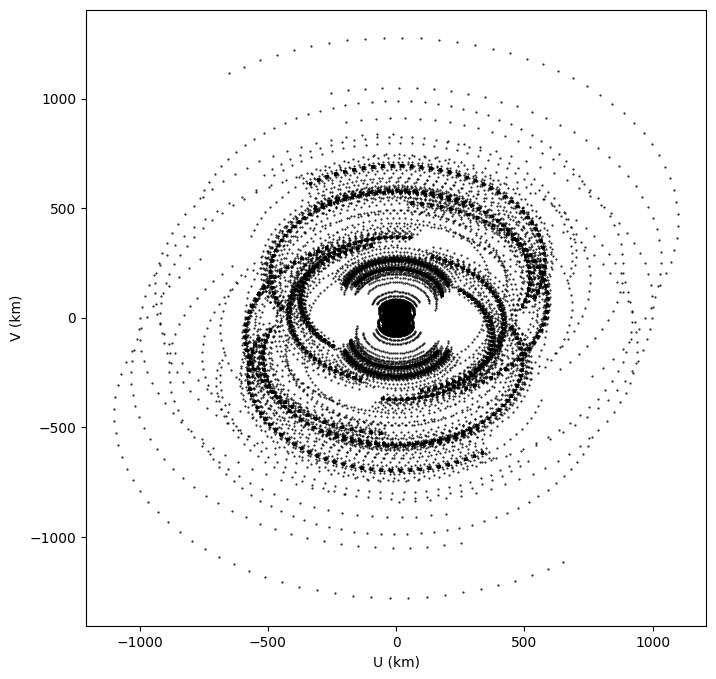

In [20]:
from astropy.constants import c
c = c.to('m/s').value

with fits.open('woden_P18Hetdex03_band01.uvfits') as hdu:
    uu = (hdu[0].data['UU']*c)/1e+3
    vv = (hdu[0].data['VV']*c)/1e+3
    
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
axs.plot(uu, vv, 'k.', ms=1)
axs.plot(-uu, -vv, 'k.', ms=1)
axs.set_xlabel('U (km)')
axs.set_ylabel('V (km)')

plt.show()

Thems some long baselines. Convert the UVFITS to an MS. Below is the function that's in `woden_uv2ms.py`. Just copied it here to show what's going on.

In [21]:
from pyuvdata import UVData
from subprocess import call
import os

def make_ms(uvfits_file, no_delete=False):
    """Takes a path to a uvfits file, checks it exists, and converts it to
    a measurement set of the same name at the same location"""

    ##If file exists, attempt to tranform it
    if os.path.isfile(uvfits_file):
        ##Get rid of '.uvfits' off the end of the file
        name = uvfits_file[:-7]
        ##Delete old measurement set if requested
        if no_delete:
            pass
        else:
            call("rm -r %s.ms" %name,shell=True)

        UV = UVData()
        UV.read(uvfits_file)
        
        UV.write_ms("{:s}.ms".format(name))
        
    else:
        ##print warning that uvfits file doesn't exist
        print("Could not find the uvfits specified by the path: "
              "\t{:s}. Skipping this tranformation".format(uvfits_file))
        

make_ms('woden_P18Hetdex03_band01.uvfits')

The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 84.15218364124303 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 84.15218364124303 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).


Now let's CLEAN it. I"m not sure of the best way to do this, but this at least gives us an image. Fair warning, this took 22m30s on my desktop.

In [22]:
cmd = 'wsclean -name woden_P18Hetdex03 -niter 20000 '
cmd += '   -size 4096 4096 -scale 1.5asec '
cmd += '   -weight briggs 0 '
cmd += '   -auto-threshold 0.5 -auto-mask 3 -pol I -multiscale '
cmd += '   -j 12 -mgain 0.85 -no-update-model-required '
cmd += '   -beam-size 6 '
cmd += '   -abs-mem 25 '
cmd += '   woden_P18Hetdex03_band01.ms'

##My local WSClean installation is borked, so I have to print the command and run it manually
# print(cmd)
call(cmd, shell=True)


WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  134-154 (40)
Reordering woden_P18Hetdex03_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for woden_P18Hetdex03_band01.ms
Detected 62.7 GB of system memory, usage limited to 25 GB (frac=100%, abs limit=25GB)
Opening reordered part 0 spw 0 for woden_P18Hetdex03_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[0.00121652:45192.3] lambdas, maxuvw=99222 lambd

0

I'm sure this isn't an optimal way to do the CLEANing, and I might be able to go deeper, but this is good enough for a comparison. Let's see what we get!

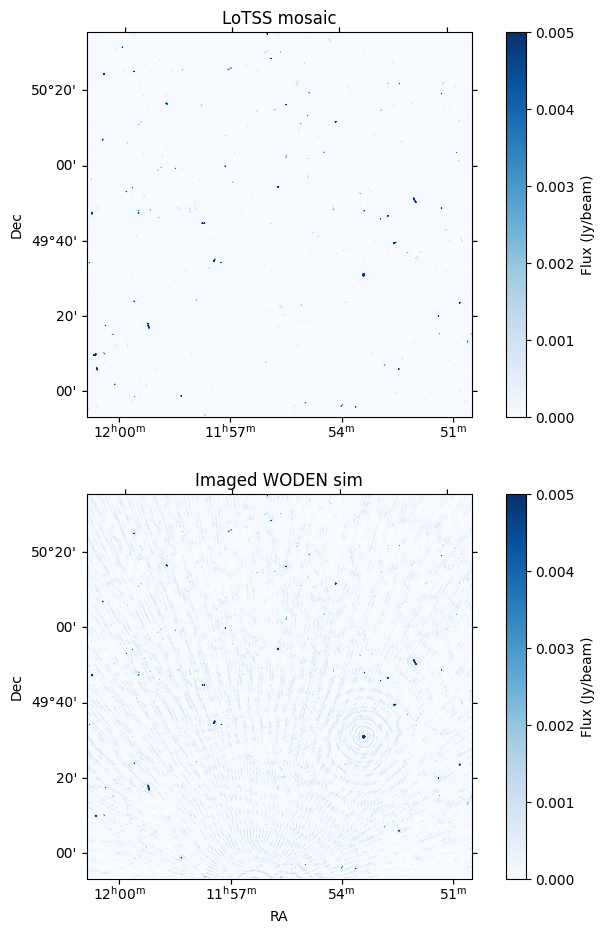

In [23]:

fig = plt.figure(figsize=(9, 11))

ax1 = fig.add_subplot(211, projection=wcs)
ax1.imshow(data, origin='lower', cmap='Blues', vmin=0, vmax=1e-3)

half_width=2048

ax1.set_xlim(cent_x - half_width, cent_x + half_width)
ax1.set_ylim(cent_y - half_width, cent_y + half_width)

vmax = 5e-3

im = ax1.imshow(data, origin='lower', cmap='Blues', vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax1, label='Flux (Jy/beam)')
ax1.set_title('LoTSS mosaic')

with fits.open('woden_P18Hetdex03-image.fits') as hdu:
    wcs_woden = WCS(hdu[0].header).celestial
    data_woden = np.squeeze(hdu[0].data)

ax2 = fig.add_subplot(212, projection=wcs_woden)

im = ax2.imshow(data_woden, origin='lower', cmap='Blues', vmin=0, vmax=vmax)
plt.colorbar(im, ax=ax2, label='Flux (Jy/beam)')
ax2.set_title('Imaged WODEN sim')

ax1.set_xlabel(' ')
ax1.set_ylabel('Dec')
ax1.set_xticklabels([])

ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')


# plt.tight_layout()
plt.show()

OK, so obviously the CLEAN on the WODEN sim isn't the greatset. This image is not beam corrected, so sources towards the edge of the field appear dimmer. And of course I cropped the sky model to the cutout size, so we're missing some sources from the corners. But overall I reckon this is a decent example of what you can do, and we're matching reality pretty well.